## Lunar lander TD-0 with an adaptive Kalman filter
### Using SARSA

In [5]:
import gym
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import njit
from scipy.stats import norm

In [2]:
np.set_printoptions(linewidth=200)
%config InlineBackend.figure_format = "retina"
sns.set_palette("colorblind")

In [ ]:
env = gym.make("LunarLander-v2")

## Single run

## The action-value function

$$
    q(s, a, {\bf w}) = {\bf w}_a^\intercal\phi(s)
$$

In [4]:
actions = np.arange(4)
n_actions = 4

## Experts-based by single step

In [51]:
def logsumexp(x, axis=None):
    c = np.nanmax(x)
    return c + np.log(np.nansum(np.exp(x - c), axis=axis))


def phi(s):
    sprime = np.concatenate([
        np.ones(1), s, np.sin(s), np.cos(s),
    ])
    return sprime

def action_value_expert(W, s, a, k):
    """
    Action-value for the k-th expert
    """
    w = W[k, a]
    return w @ phi(s)


def eps_greedy_choice_experts(W, s, weights, actions, experts, eps):
    u = np.random.uniform()
    if u < eps:
        a = np.random.choice(4)
    else:
        action_value_estimates = action_value_expert(M, s, actions[None, :], experts[:, None])
        action_value_estimates = np.einsum("ka,k->a", action_value_estimates, weights)
        a = choose_max_action(action_value_estimates)
    return a


def choose_max_action(action_value_est):
    vmax = action_value_est.max()
    if np.sum(vmax == action_value_est) == 1:
        return np.argmax(action_value_est)
    else: # break ties
        actions = np.arange(len(action_value_est))
        av_sub = actions[action_value_est == vmax]
        return np.random.choice(av_sub)


def update_experts_uvals(weights, log_likelihoods, learning_rate, measurement, n_inner=1):
    yt = np.atleast_1d(measurement)
    for i in range(n_inner):
        u_vals = weights * yt
        log_weights = u_vals - logsumexp(u_vals)
        log_weighted_log_likelihood = log_likelihoods + log_weights
        log_weighted_log_likelihood = log_weighted_log_likelihood - logsumexp(log_weighted_log_likelihood)
        weights = weights + learning_rate * (np.exp(log_weighted_log_likelihood) - np.exp(log_weights)) * measurement
    return weights


def build_weights(u_vals, measurement):
    yt = np.atleast_1d(measurement)
    log_weights = u_vals * yt
    log_weights = log_weights - logsumexp(log_weights)
    return np.exp(log_weights)


def update_qweights_akf(M, Sigma, k, s, a, r, s_next, a_next, gamma, Rt, Qt):
    """
    Update a bank of KF elements
    """
    M = np.copy(M)
    Sigma = np.copy(Sigma)

    m = M[k, a]
    Sigma_prev = Sigma[k, a] + np.eye(len(m)) * Qt[k]
    gphi = phi(s)
    S = np.einsum("i,ij,j->", gphi, Sigma_prev, gphi) + Rt
    K = np.linalg.solve(S, (Sigma_prev @ gphi)[None, :]).T

    # SARSA
    # td_err = r + gamma * action_value_expert(M, s_next, a_next, k) - action_value_expert(M, s, a, k)
    # Q-learning
    td_err = r + gamma * action_value_expert(M, s_next, actions, k).max() - action_value_expert(M, s, a, k)
    
    m = m + (K * td_err).ravel()
    Sigma_next = Sigma_prev - K @ S @ K.T
    
    log_prob = norm(loc=0.0, scale=np.sqrt(S.squeeze())).logpdf(td_err)

    M[k, a] = m
    Sigma[k, a] = Sigma_next

    return M, Sigma, td_err, log_prob

## Experts-based method

In [52]:
q_values = [0.0, 1e-4]
q_values = [0.0, 1e-4]
n_experts = len(q_values)
experts = np.arange(n_experts)

In [53]:
np.random.seed(314)
M = np.zeros((n_experts, n_actions, dim_phi))
# M = np.random.randn(n_experts, n_actions, dim_phi)
Sigma = np.einsum("k,a,ij->kaij", np.ones(n_experts), np.ones(n_actions), np.eye(dim_phi)) * 10.0
u_vals = np.ones(n_experts)
weights = u_vals / u_vals.sum()
log_likelihoods = np.ones(n_experts)

n_inner = 5
n_steps = 10_000
eps= 5e-4
# gamma = 0.9999
gamma = 0.9999
eta = 1.0
Rt = np.eye(1) * 1.0

env = gym.make("LunarLander-v2")
observation, info = env.reset(seed=314)
# action = env.action_space.sample()
action = eps_greedy_choice_experts(M, observation, weights, actions, experts, eps)

n_episodes = 0
episode_reward = 0.0
ewm_reward = 0.0

final_rewards = []
hist_weights = []
episodes = []
for t in (pbar := tqdm(range(n_steps))):
    observation_next, reward, terminated, truncated, info = env.step(action)
    action_next = eps_greedy_choice_experts(M, observation_next, weights, actions, experts, eps)

    reset = terminated or truncated
    gamma_step = 0.0 if reset else gamma
    
    for k in experts:
        M, Sigma, td_err, log_prob = update_qweights_akf(
                M, Sigma, k, observation, action, reward, observation_next, action_next,
                gamma_step, Rt, q_values 
            )
        log_likelihoods[k] = log_prob

    u_vals = update_experts_uvals(u_vals, log_likelihoods, eta, reward, n_inner=n_inner)
    weights = build_weights(u_vals, reward)
    
    alpha = 0.3
    
    if reset:
        final_rewards.append(episode_reward)
        observation, info = env.reset()
        action = eps_greedy_choice_experts(M, observation_next, weights, actions, experts, eps)
        
        ewm_reward = ewm_reward * (1 - alpha) + episode_reward * alpha
        episode_reward = 0.0
        n_episodes += 1
    else:
        episode_reward += reward
        observation = observation_next
        action = action_next
    hist_weights.append(weights)
    
    if t % 1000 == 0:
        pbar.set_description(f"{ewm_reward:0.2f}")
        
final_rewards = pd.Series(final_rewards)
hist_weights = pd.DataFrame(hist_weights, columns=q_values)

  0%|                                                                                                                                                          | 0/10000 [00:00<?, ?it/s]/Users/gerardoduran/mambaforge/envs/py310/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
-345.53: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1007.09it/s]


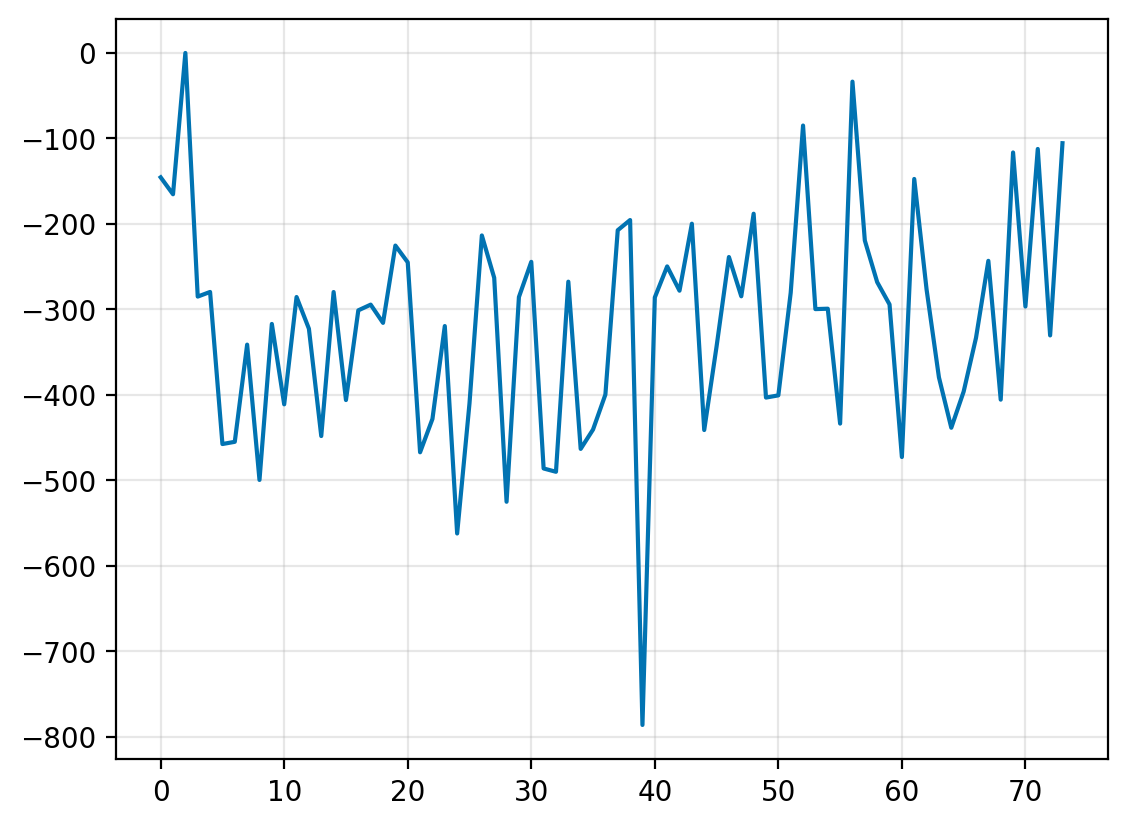

In [54]:
final_rewards.plot()
plt.grid(alpha=0.3)

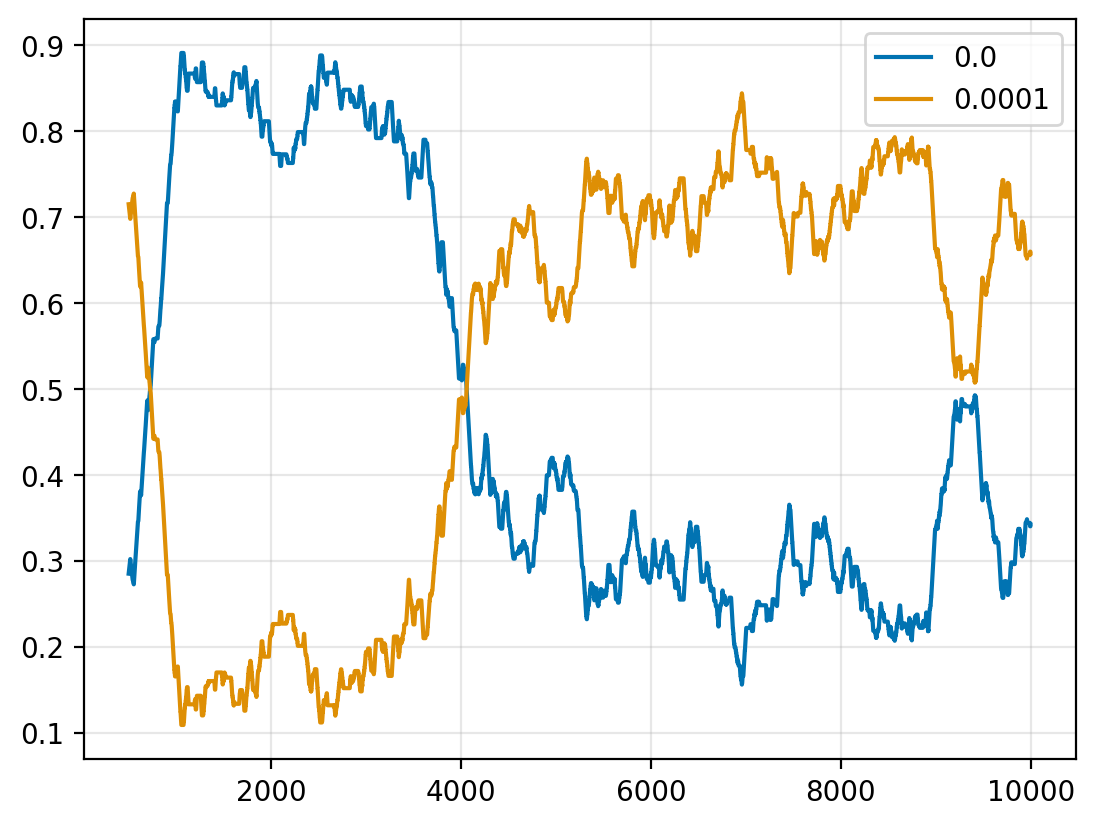

In [55]:
hist_weights.rolling(500).mean().plot()
plt.grid(alpha=0.3)

final_rewards.ewm(span=50, min_periods=100).mean().plot(c="crimson")
ymin, ymax = plt.ylim()
final_rewards.iloc[100:].plot(zorder=0, c="gray", alpha=0.7)
plt.ylim(ymin, ymax)
plt.title("Episodic reward")
plt.xlabel("Episodes")
plt.grid(alpha=0.3)

----

## Episode-based mixture of experts

In [160]:
from scipy.stats import t as tdist

In [366]:
def logsumexp(x, **kwargs):
    c = np.nanmax(x)
    return c + np.log(np.nansum(np.exp(x - c), **kwargs))


def phi(s):
    sprime = np.concatenate([
        np.ones(1), s, np.sin(s), np.cos(s),
    ])
    return sprime

def action_value_expert(W, s, a, k):
    """
    Action-value for the k-th expert
    """
    w = W[k, a]
    return w @ phi(s)


def eps_greedy_choice_experts(W, s, weights, actions, experts, eps):
    u = np.random.uniform()
    if u < eps:
        a = np.random.choice(4)
    else:
        action_value_estimates = action_value_expert(M, s, actions[None, :], experts[:, None])
        action_value_estimates = np.einsum("ka,k->a", action_value_estimates, weights)
        a = choose_max_action(action_value_estimates)
    return a


def choose_max_action(action_value_est):
    vmax = action_value_est.max()
    if np.sum(vmax == action_value_est) == 1:
        return np.argmax(action_value_est)
    else: # break ties
        actions = np.arange(len(action_value_est))
        av_sub = actions[action_value_est == vmax]
        return np.random.choice(av_sub)


def update_experts_uvals(weights, log_likelihoods, learning_rate, measurements, n_inner=1):
    yt = np.atleast_1d(measurements)
    for i in range(n_inner):
        u_vals = np.einsum("m,t->tm", weights, yt)
        log_weights = u_vals - logsumexp(u_vals, axis=1, keepdims=True)
        log_weighted_log_likelihood = log_likelihoods + log_weights
        log_weighted_log_likelihood = log_weighted_log_likelihood - logsumexp(log_weighted_log_likelihood, axis=1, keepdims=True)

        grad_G = (np.exp(log_weighted_log_likelihood) - np.exp(log_weights)) * yt[:, None]
        weights = weights + learning_rate * grad_G.mean(axis=0)
        
    if np.isinf(weights).any():
        import pdb; pdb.set_trace()
    return weights


def build_weights(u_vals, measurements):
    yt = np.atleast_1d(measurements)
    log_weights = np.einsum("m,t->tm", u_vals, yt)
    log_weights = log_weights - logsumexp(log_weights, axis=1, keepdims=True)
    
    return np.exp(log_weights).mean(axis=0)


def update_qweights_akf(M, Sigma, k, s, a, r, s_next, a_next, gamma, Rt, Qt):
    """
    Update a bank of KF elements
    """
    M = np.copy(M)
    Sigma = np.copy(Sigma)

    m = M[k, a]
    Sigma_prev = Sigma[k, a] + np.eye(len(m)) * Qt[k]
    gphi = phi(s)
    S = np.einsum("i,ij,j->", gphi, Sigma_prev, gphi) + Rt
    K = np.linalg.solve(S, (Sigma_prev @ gphi)[None, :]).T

    # SARSA
    td_err = r + gamma * action_value_expert(M, s_next, a_next, k) - action_value_expert(M, s, a, k)
    # Q-learning
    # td_err = r + gamma * action_value_expert(M, s_next, actions, k).max() - action_value_expert(M, s, a, k)
    
    m = m + (K * td_err).ravel()
    Sigma_next = Sigma_prev - K @ S @ K.T
    
    # log_prob = norm(loc=0.0, scale=np.sqrt(S.squeeze())).logpdf(td_err)
    # log_prob = tdist(loc=0.0, scale=np.sqrt(S.squeeze()), df=20.0).logpdf(td_err)
    sigma2 = S.squeeze()
    log_prob = -np.sqrt(sigma2) - td_err ** 2 / (2 * sigma2)
    log_prob = np.maximum(-700, log_prob)
    # log_prob = log_prob / (1 + np.power(td_err, 2) / (sigma2 * 20.0 ** 2))

    M[k, a] = m
    Sigma[k, a] = Sigma_next

    return M, Sigma, td_err, log_prob

In [375]:
# q_values = [0.0, 1e-6, 1e-5, 1e-4, 1e-3]
q_values = [1e-8, 1e-4, 1.0]
n_experts = len(q_values)
experts = np.arange(n_experts)

np.random.seed(314)
M = np.zeros((n_experts, n_actions, dim_phi))
# M = np.random.randn(n_experts, n_actions, dim_phi)
Sigma = np.einsum("k,a,ij->kaij", np.ones(n_experts), np.ones(n_actions), np.eye(dim_phi)) * 10.0
u_vals = np.ones(n_experts)
weights = u_vals / u_vals.sum()
# log_likelihoods = np.ones(n_experts)

n_inner = 5
n_steps = 50_000
eps= 5e-4
gamma = 0.9999
eta = 0.8
Rt = np.eye(1) * 1.0

env = gym.make("LunarLander-v2")
observation, info = env.reset(seed=314)
action = eps_greedy_choice_experts(M, observation, weights, actions, experts, eps)

n_episodes = 0
episode_reward = 0.0
ewm_reward = 0.0

final_rewards = []
hist_weights = []
episodes = []

log_likelihoods_episode = []
rewards_episode = []

for t in (pbar := tqdm(range(n_steps))):
    observation_next, reward, terminated, truncated, info = env.step(action)
    action_next = eps_greedy_choice_experts(
        M, observation_next, weights, actions, experts, eps
    )

    reset = terminated or truncated
    gamma_step = 0.0 if reset else gamma

    ll_experts = np.zeros(n_experts)
    for k in experts:
        M, Sigma, td_err, log_prob = update_qweights_akf(
                M, Sigma, k, observation, action, reward, observation_next, action_next,
                gamma_step, Rt, q_values 
            )
        ll_experts[k] = log_prob
    rewards_episode.append(reward)
    log_likelihoods_episode.append(ll_experts)
    
    alpha = 0.3
    
    if reset:
        log_likelihoods_episode = np.array(log_likelihoods_episode)
        rewards_episode = np.array(rewards_episode)
        u_vals = update_experts_uvals(
            u_vals, log_likelihoods_episode, eta, rewards_episode, n_inner=n_inner
        )
        weights = build_weights(u_vals, rewards_episode)
        hist_weights.append(weights)
        
        final_rewards.append(episode_reward)
        observation, info = env.reset()
        action = eps_greedy_choice_experts(M, observation_next, weights, actions, experts, eps)

        ewm_reward = ewm_reward * (1 - alpha) + episode_reward * alpha
        episode_reward = 0.0
        log_likelihoods_episode = [] # reset log-likelihoods
        rewards_episode = [] # reset rewards in episode
        n_episodes += 1
    else:
        episode_reward += reward
        observation = observation_next
        action = action_next
    
    if t % 1000 == 0:
        pbar.set_description(f"{ewm_reward:0.2f}")
        
final_rewards = pd.Series(final_rewards)
hist_weights = pd.DataFrame(hist_weights, columns=q_values)

  0%|                                                                                                                                                          | 0/50000 [00:00<?, ?it/s]/Users/gerardoduran/mambaforge/envs/py310/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
-282.75: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:11<00:00, 4491.73it/s]


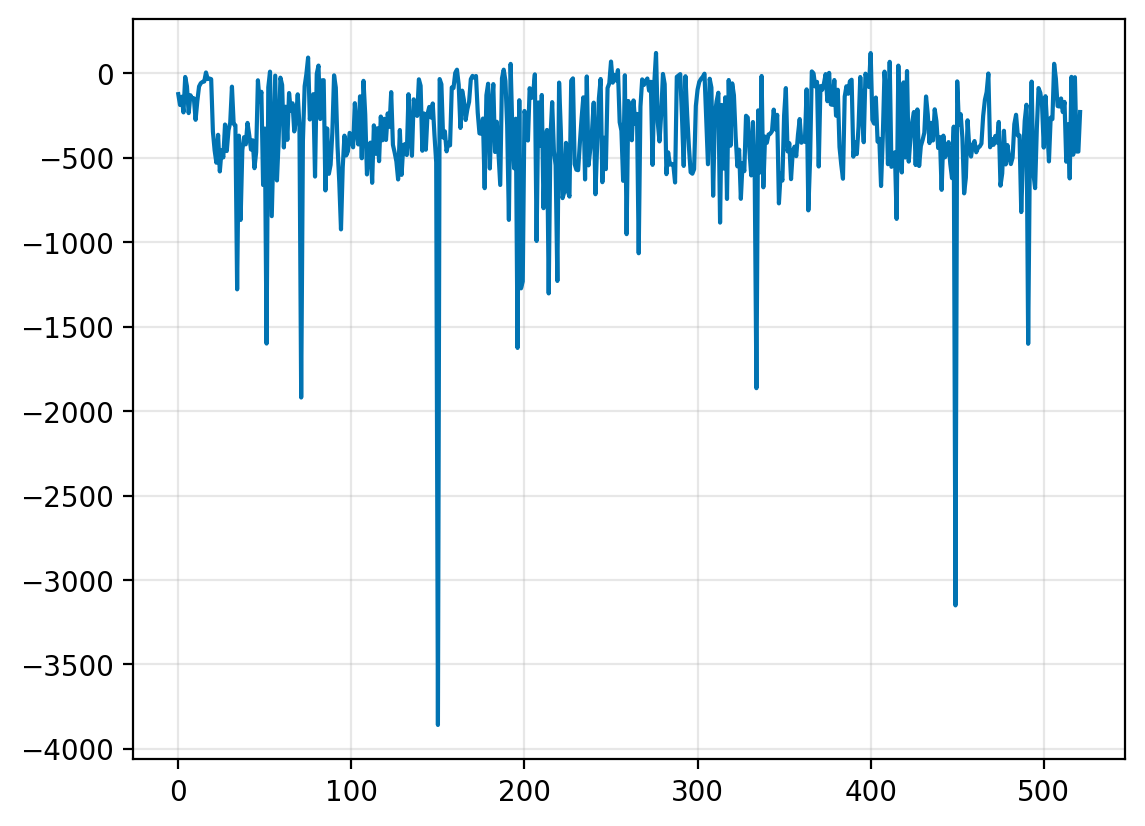

In [376]:
final_rewards.plot()
plt.grid(alpha=0.3)

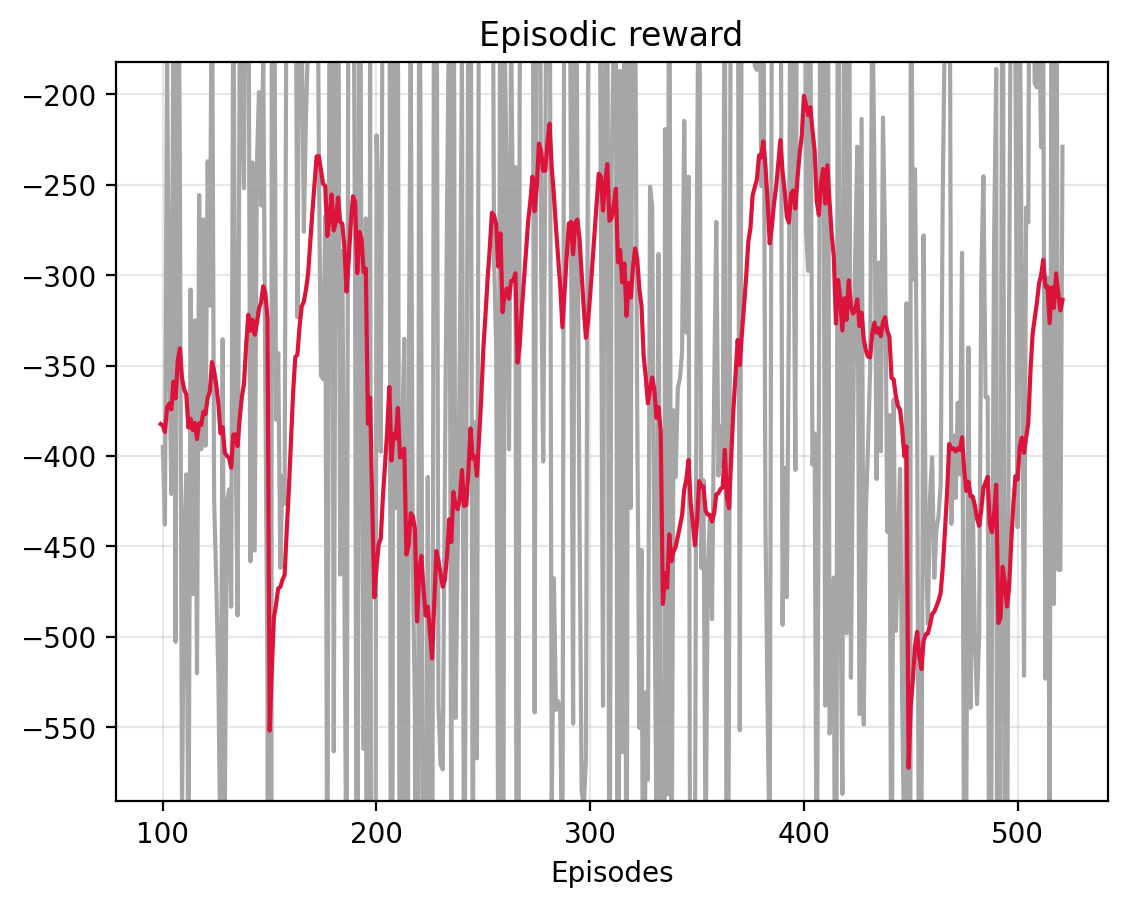

In [377]:
final_rewards.ewm(span=30, min_periods=100).mean().plot(c="crimson")
ymin, ymax = plt.ylim()
final_rewards.iloc[100:].plot(zorder=0, c="gray", alpha=0.7)
plt.ylim(ymin, ymax)
plt.title("Episodic reward")
plt.xlabel("Episodes")
plt.grid(alpha=0.3)

<Axes: >

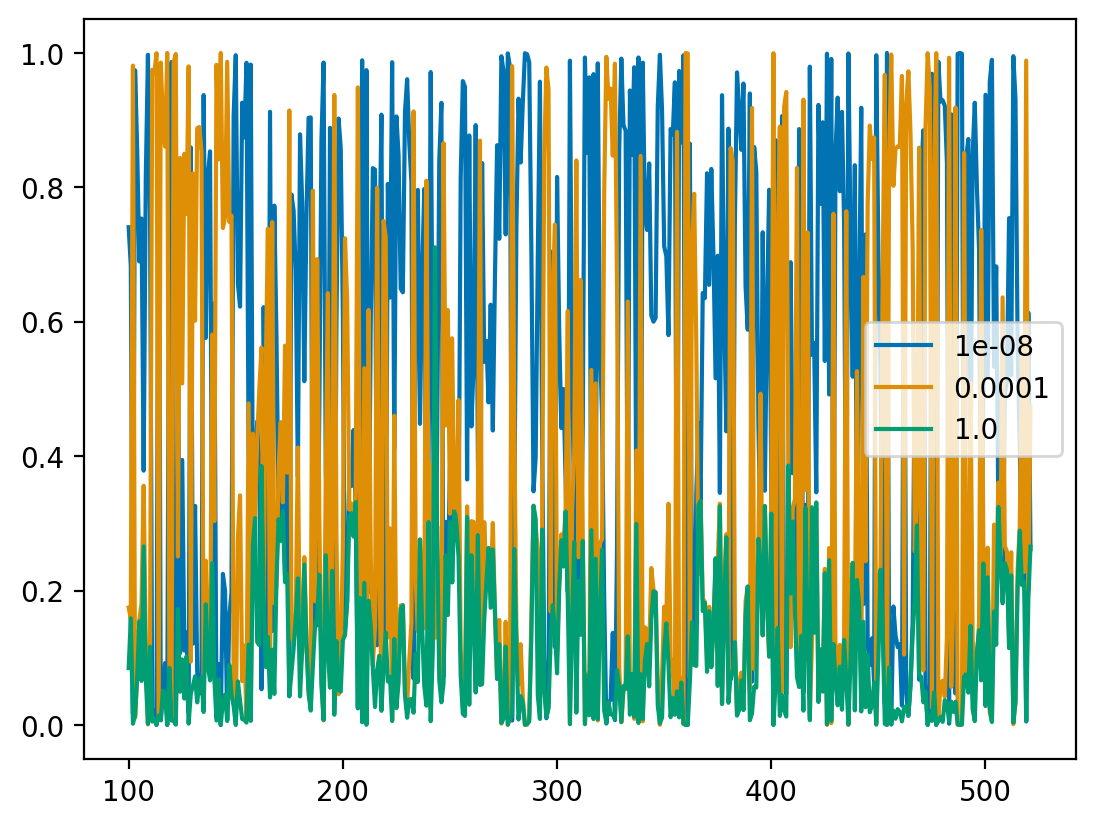

In [378]:
hist_weights[100:].plot()

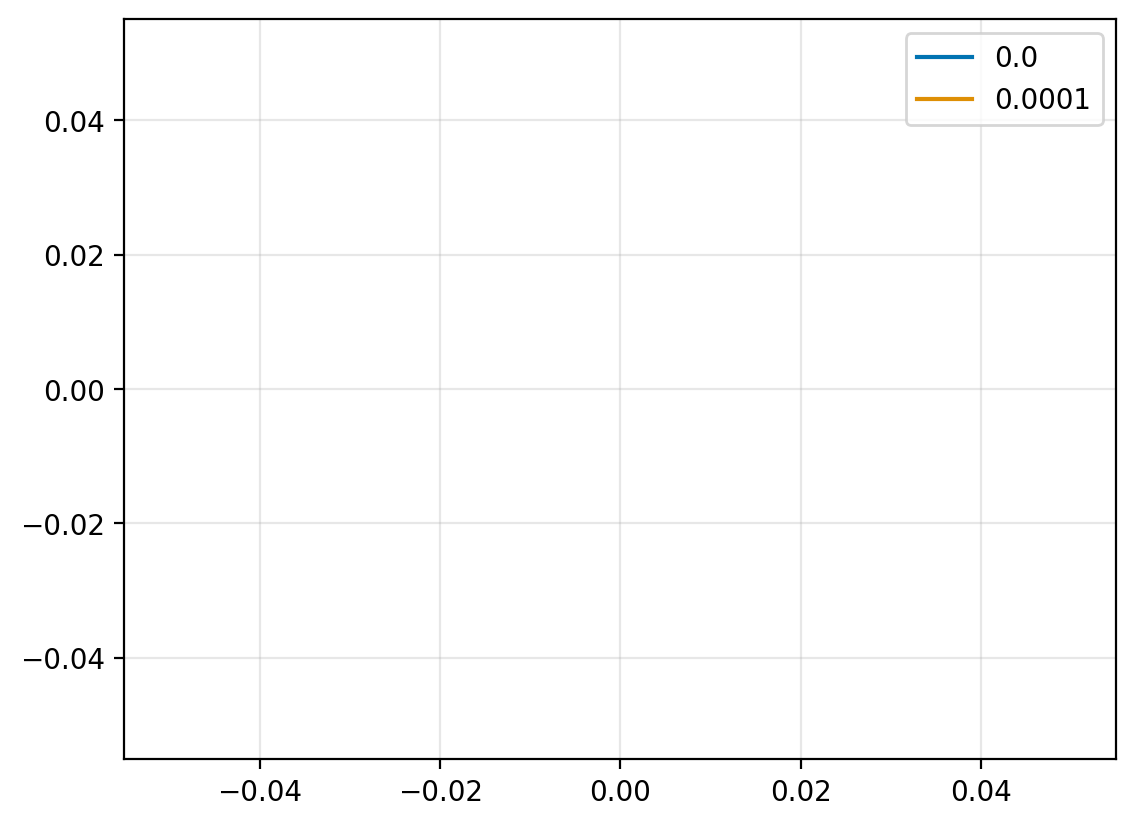

In [235]:
hist_weights.rolling(500).mean().plot()
plt.grid(alpha=0.3)

---

## Kalman filter based method

In [39]:
def phi(s):
    sprime = np.concatenate([
        np.ones(1), s, np.sin(s), np.cos(s),
    ])
    return sprime

def action_value(W, s, a):
    w = W[a]
    return w @ phi(s)

def grad_action_value(W, s, a):
    return phi(s)


def eval_action_value(W, s, actions):
    q_a = np.array([action_value(W, s, ai) for ai in actions])
    return q_a


def choose_max_action(action_value_est):
    vmax = action_value_est.max()
    if np.sum(vmax == action_value_est) == 1:
        return np.argmax(action_value_est)
    else: # break ties
        actions = np.arange(len(action_value_est))
        av_sub = actions[action_value_est == vmax]
        return np.random.choice(av_sub)


def eps_greedy_choice(W, s, eps):
    u = np.random.uniform()
    if u < eps:
        a = np.random.choice(4)
    else:
        action_value_estimates = eval_action_value(W, s, actions)
        a = choose_max_action(action_value_estimates)
    return a


def update_qweights(W, s, a, r, s_next, a_next, gamma, alpha):
    """
    Update weights using SARSA algorithm
    """
    W = np.copy(W)
    td_err = r + gamma * action_value(W, s_next, a_next) - action_value(W, s, a)
    w = W[a] + alpha * td_err * grad_action_value(W, s, a)
    W[a] = w
    return W


def update_qweights_kf(M, Sigma, s, a, r, s_next, a_next, gamma, Rt, qt):
    """
    A first attempt
    """
    M = np.copy(M)
    Sigma = np.copy(Sigma)
    
    m = M[a]
    Sigma_prev = Sigma[a] + np.eye(len(m)) * qt
    gphi = grad_action_value(M, s, a)

    S = np.einsum("i,ik,k->", gphi, Sigma_prev, gphi) + Rt
    K = np.linalg.solve(S, (Sigma_prev @ gphi)[None, :]).T

    # SARSA
    td_err = r + gamma * action_value(M, s_next, a_next) - action_value(M, s, a)
    # Q-learning
    # td_err = r + gamma * action_value(M, s_next, actions).max() - action_value(M, s, a)

    m = m + (K * td_err).ravel()
    Sigma_next = Sigma_prev - K @ S @ K.T

    M[a] = m
    Sigma[a] = Sigma_next
    
    return M, Sigma, td_err

In [48]:
n_steps = 100_000
eps = 5e-4
gamma = 0.9999
Rt = np.eye(1) * 1.0

all_rewards = np.zeros(n_steps)
all_td_errs = np.zeros(n_steps)

env = gym.make("LunarLander-v2")
observation, info = env.reset(seed=314)
final_rewards = []

checkpoint_episodes = [1, 250, 500, 750, 1000, 1250, 1500]
checkpoint_weights = []

dim_phi = len(phi(observation))
np.random.seed(314)
M = np.random.randn(n_actions, dim_phi)
M = M.astype("float32")
M = np.zeros((n_actions, dim_phi))
Sigma = np.einsum("a,ij->aij", np.ones(n_actions), np.eye(dim_phi)) * 10.0


action = eps_greedy_choice(M, observation, eps)
n_episodes = 0
episode_reward = 0.0

beta = 0.6
ewm_reward = 0.0

for t in (pbar := tqdm(range(n_steps))):
    observation_next, reward, terminated, truncated, info = env.step(action)
    action_next = eps_greedy_choice(M, observation_next, eps)

    reset = terminated or truncated
    gamma_step = 0.0 if reset else gamma

    # qt = 1e-4 if n_episodes < 350 else 0.0
    M, Sigma, td_err = update_qweights_kf(
        M, Sigma, observation, action, reward, observation_next, action_next, gamma_step, Rt, qt
    )
    
    if reset:
        final_rewards.append(episode_reward)
        observation, info = env.reset()
        action = eps_greedy_choice(M, observation, eps)
        ewm_reward = ewm_reward * (1 - beta) + episode_reward * beta
        episode_reward = 0.0
        
        if n_episodes in checkpoint_episodes:
            checkpoint_weights.append(M)
        n_episodes += 1
    else:
        episode_reward += reward
        observation = observation_next
        action = action_next

    if t % 10_000 == 0:
        pbar.set_description(f"{ewm_reward:0.2f}")
    all_rewards[t] = reward
    all_td_errs[t] = td_err

# attach last 
checkpoint_weights.append(M)
checkpoint_episodes.append(n_episodes)

checkpoint_weights = np.stack(checkpoint_weights)
final_rewards = pd.Series(final_rewards)
print(f"\n{all_rewards.sum()}")
env.close()

  0%|                                                                                                                                                         | 0/100000 [00:00<?, ?it/s]/Users/gerardoduran/mambaforge/envs/py310/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
85.48: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:24<00:00, 4108.69it/s]


-37598.71230704946


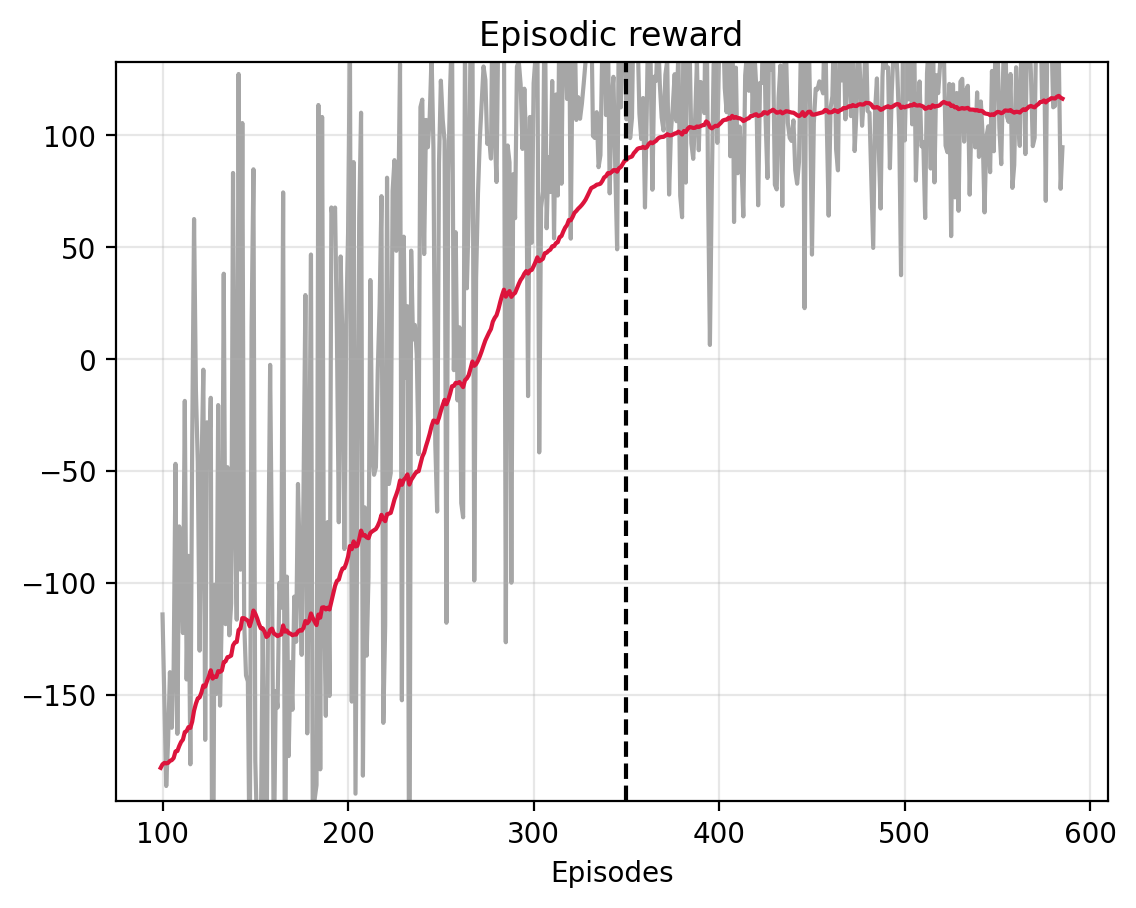

In [50]:
final_rewards.ewm(span=100, min_periods=100).mean().plot(c="crimson")
ymin, ymax = plt.ylim()
final_rewards.iloc[100:].plot(zorder=0, c="gray", alpha=0.7)
plt.ylim(ymin, ymax)
plt.axvline(x=350, c="black", linestyle="dashed")
plt.title("Episodic reward")
plt.xlabel("Episodes")
plt.grid(alpha=0.3)

## Testing policy

In [10]:
np.save("weights", W)

NameError: name 'W' is not defined

In [26]:
n_steps = 1000
eps = 5e-4

observation, info = env.reset(seed=3141)
action = eps_greedy_choice(M, observation, eps)

observations = []
rewards = []
actions_hist = []

episode_reward = 0.0
for t in range(n_steps):
    observation, reward, terminated, truncated, info = env.step(action)
    
    action = eps_greedy_choice(M, observation, eps)

    reset = terminated or truncated
    rewards.append(reward)
    actions_hist.append(action)
    observations.append(observation)
    
    if reset:
        observation, info = env.reset()
        # action = eps_greedy_choice(W, observation, eps)
        break

observations = np.array(observations)
rewards = np.array(rewards)
print(f"\n{rewards.sum()}")


-11.764115596932257


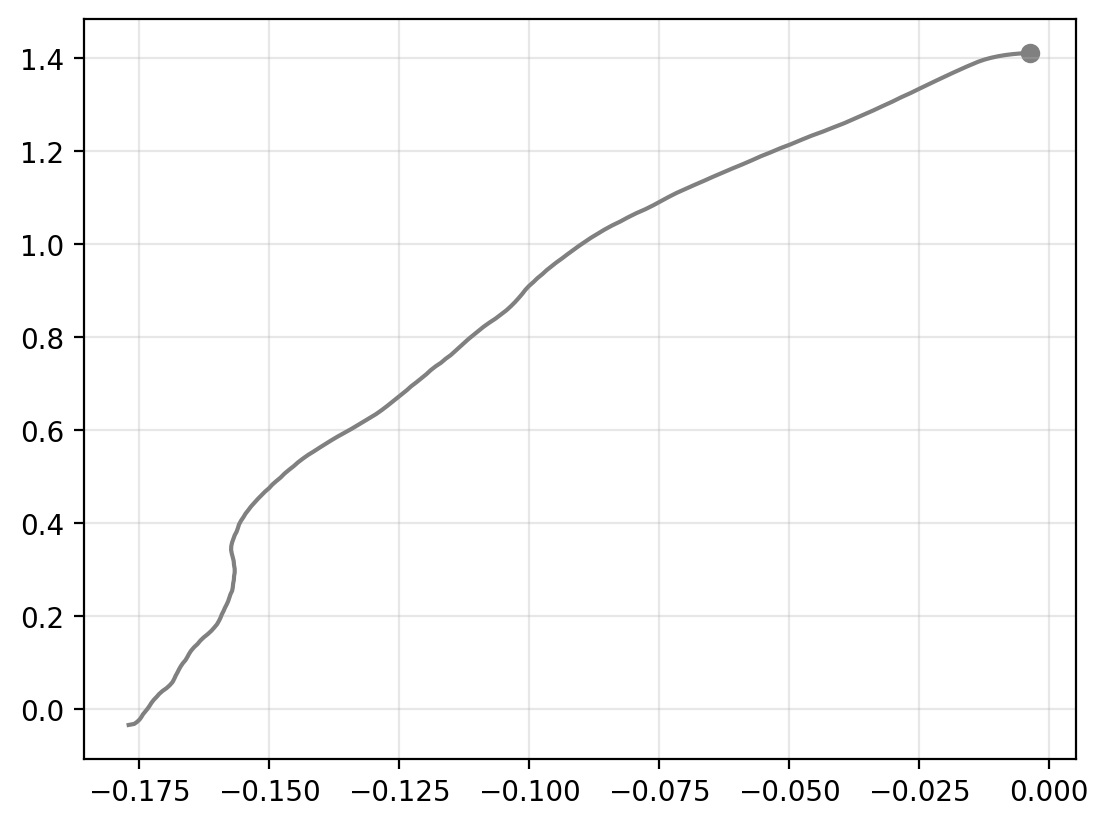

In [27]:
plt.plot(*observations[:, :2].T, c="gray")
plt.scatter(*observations[0, :2], c="gray")
plt.grid(alpha=0.3)

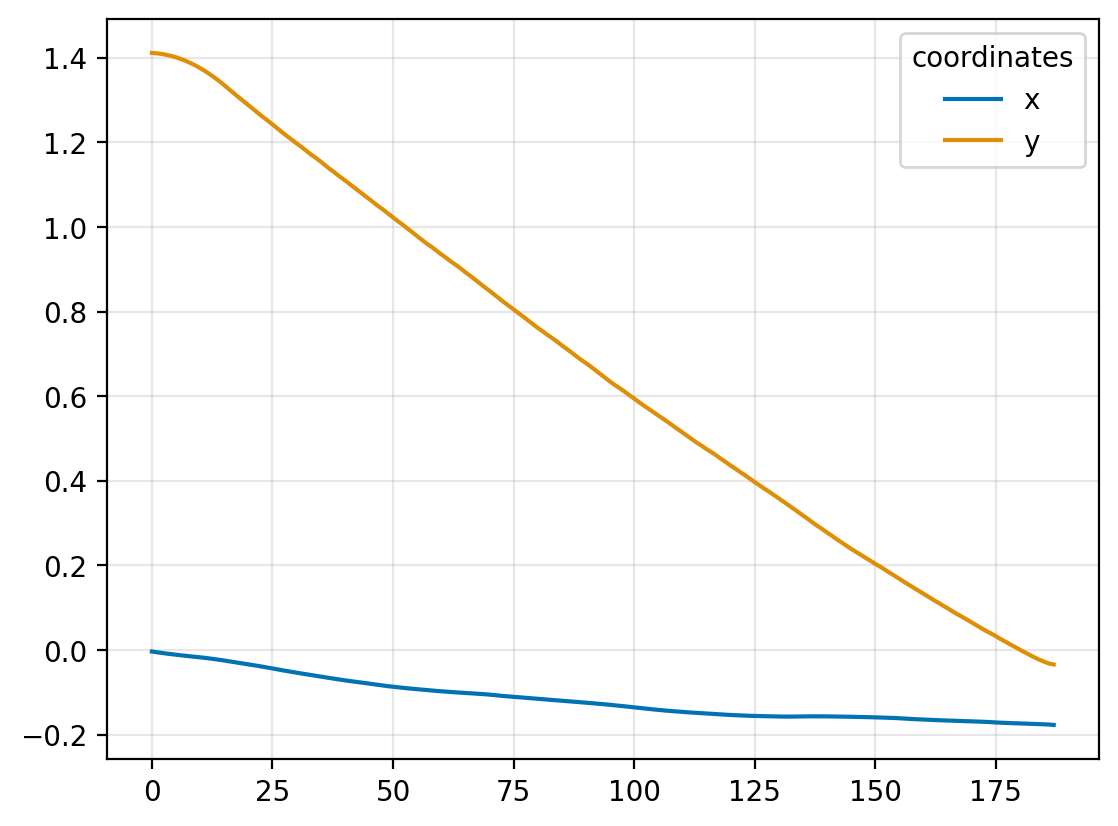

In [28]:
plt.plot(observations[:, :2], label=["x", "y"])
plt.legend(title="coordinates")
plt.grid(alpha=0.3)

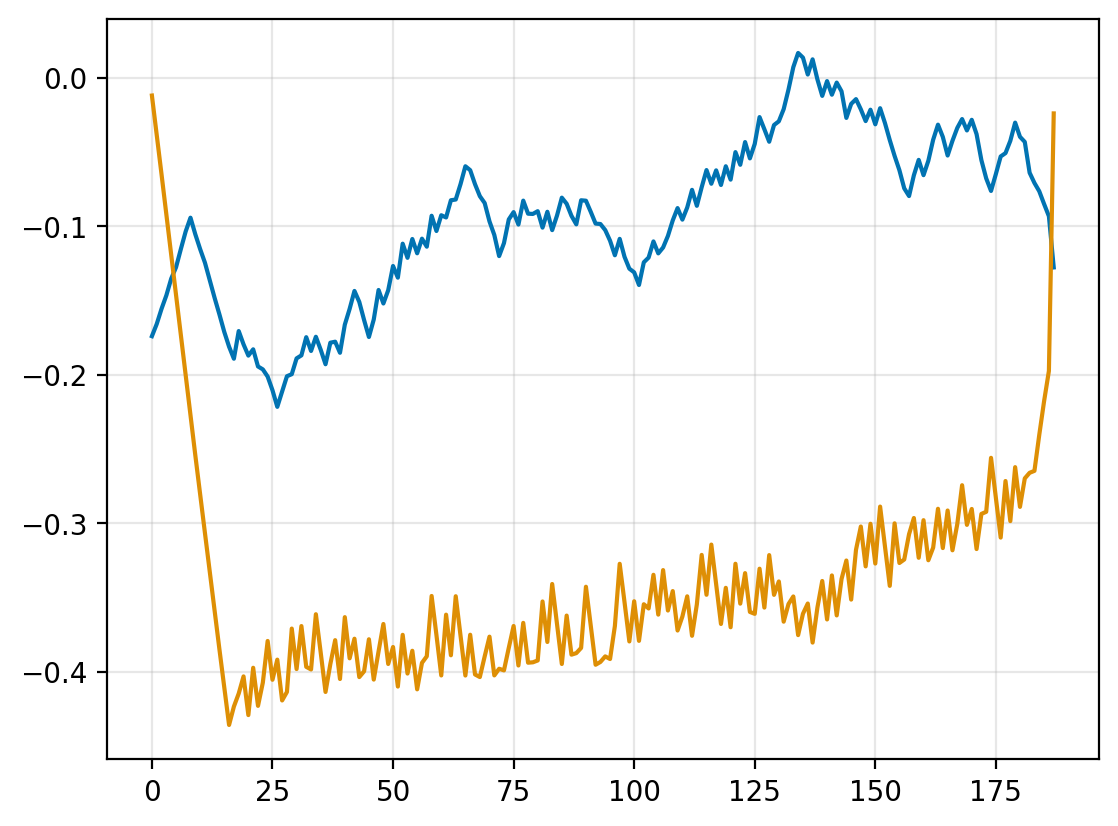

In [29]:
plt.plot(observations[:, 2:4])
plt.grid(alpha=0.3)

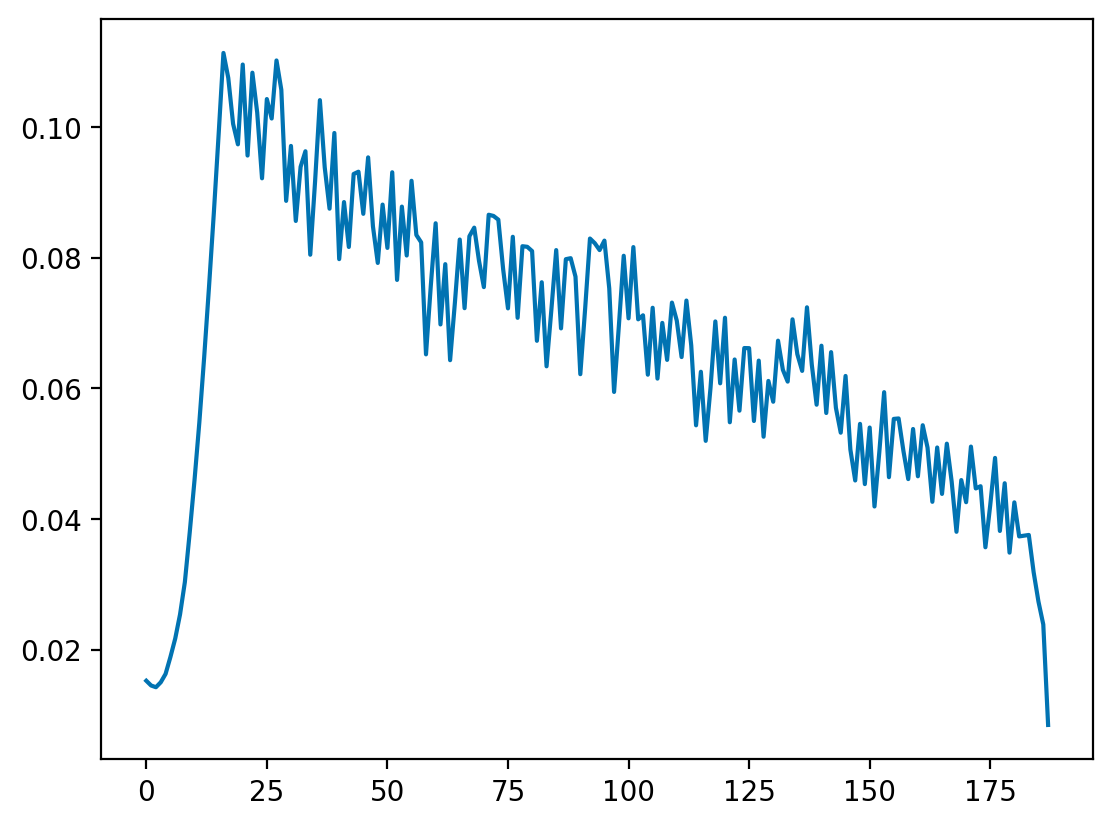

In [30]:
vel = np.power(observations[:, 2:4], 2).mean(axis=1)
plt.plot(vel)

In [31]:
observation, info = env.reset(seed=314)

In [32]:
xspace = np.linspace(-1, 1, 100)
yspace = np.linspace(0, 2, 100)
Ogrid = np.stack(np.meshgrid(xspace, yspace))
Ogrid = np.einsum("mij->ijm", Ogrid)
Fgrid = np.zeros((100, 100))

In [33]:
for i in range(100):
    for j in range(100):
        sub_pos = Ogrid[i,j]
        observation[:2] = sub_pos
        res = eval_action_value(M, observation, actions)
        Fgrid[i,j] = res.argmax()

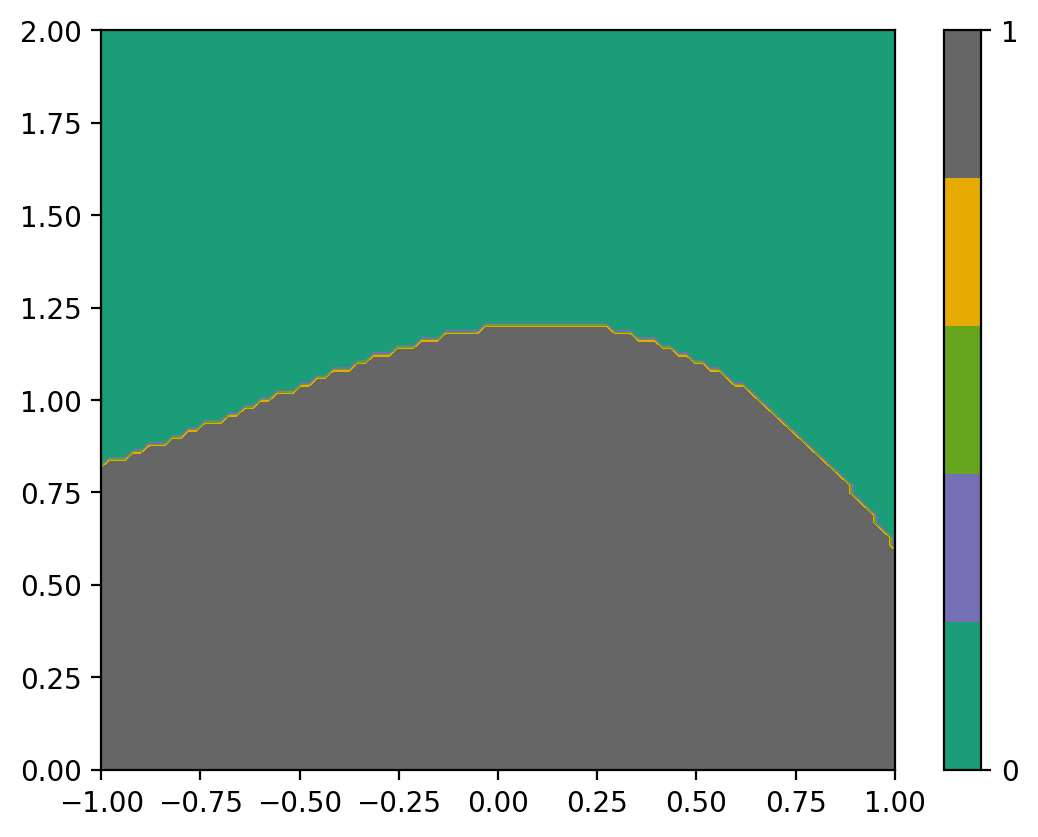

In [35]:
plt.contourf(xspace, yspace, Fgrid, cmap="Dark2", levels=4)
plt.colorbar(ticks=actions)

## Multiple runs

In [37]:
colors = np.linspace(0, 1, len(checkpoint_episodes))
colors = plt.cm.viridis(colors)

-362.88540054188906
-146.99012416927107
-29.297763716244177
-31.953938653259968


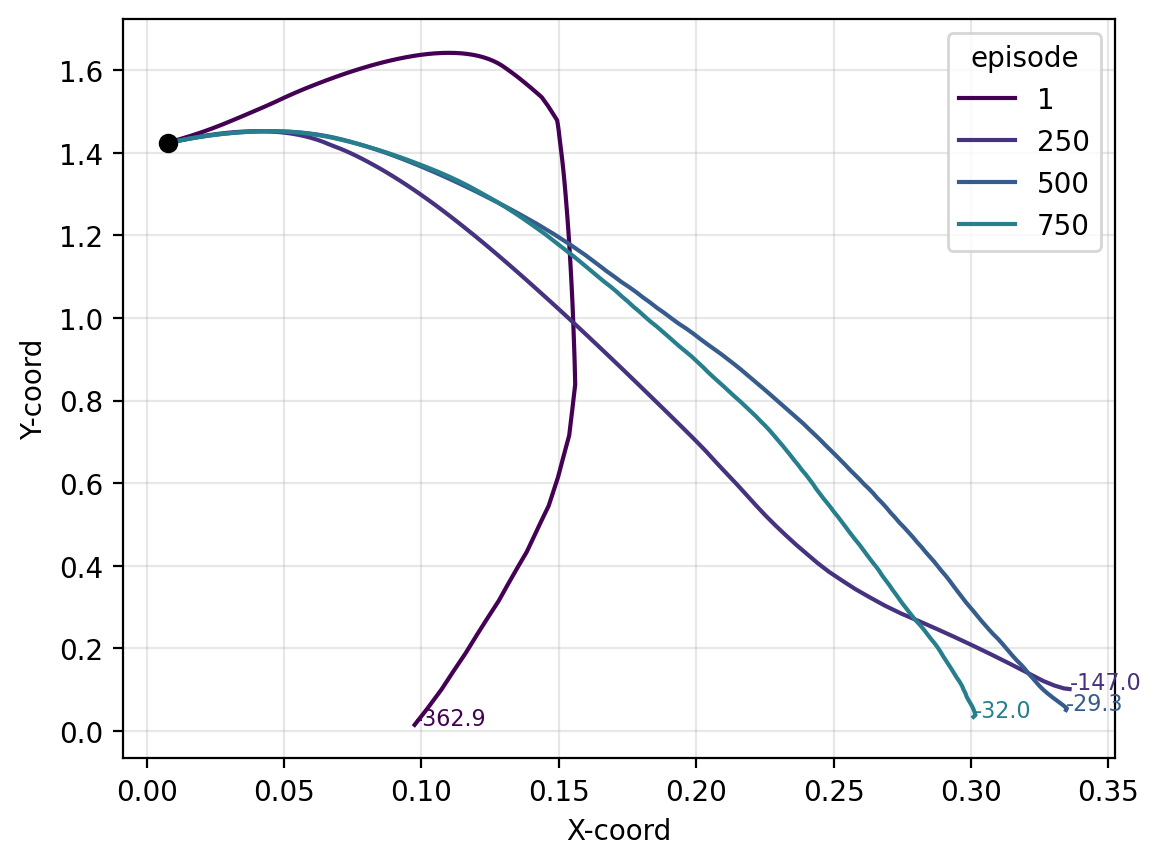

In [38]:
n_steps = 1000
eps = 5e-4

for W, episode, color in zip(checkpoint_weights, checkpoint_episodes, colors):
    observation, info = env.reset(seed=314)
    action = eps_greedy_choice(W, observation, eps)
    
    observations = []
    actions_hist = []
    
    episode_reward = 0.0
    for t in range(n_steps):
        observation, reward, terminated, truncated, info = env.step(action)
        
        action = eps_greedy_choice(W, observation, eps)
    
        reset = terminated or truncated
        actions_hist.append(action)
        observations.append(observation)
        
        episode_reward += reward
        if reset:
            observation, info = env.reset()
            # action = eps_greedy_choice(W, observation, eps)
            break
    
    observations = np.array(observations)

    plt.plot(*observations[:, :2].T, label=episode, c=color)
    
    last_x, last_y = observations[-1, :2]
    last_r = f"{episode_reward:0.1f}"
    plt.text(last_x, last_y, last_r, color=color, fontsize=8)
    print(episode_reward)

plt.scatter(*observations[0, :2], c="black", zorder=2)
plt.xlabel("X-coord")
plt.ylabel("Y-coord")
plt.legend(title="episode")
plt.grid(alpha=0.3)